# Evaluation

In this notebook we pick up the result of our hyper parameter selection and evaluate the result of hyper-parameter selection.

Based on our intended use of the model we have the following requirements:
1) The model has a better haming score than random guessing and majority class guessing.
2) The model has an F1 score of > 0.5 for all Pokémon types.
3) The model delivers results in less than 1 second.

The first requirement is a bare minimum, the second one is more strict and determines whether the model would actually be useful for us. We will consider this requirement nice to have. It should be noted that this is a very low bar to clear and is derived from this being intended as a teaching demonstrator.


Furthermore, we intend to evaluate whether the final model exhibits overfitting.

This notebook is structured as follows:
1) Training: We load data and train the model.
2) Hamming Score: we compare our model against the simple benchmarks.
3) Individual classes: we evaluate the individual Pokémon classes.
4) Time Measurement: we measure the prediction time.
5) Overfitting: We test and discuss overfitting.
6) Model Persistence: We store the trained model on hard disk so it can be used by other programs
7) Conclusion: We summarize the achieved results and discuss implications


In [1]:
# correct working directory only once 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

import random
import time
import statistics 

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from models.majority_guessing_benchmark import MajorityGuessingBenchmark
from models.random_guessing_benchmark import RandomGuessingBenchmark
from models.cnn_builder import CNNBuilder 
from models.model_persistence import save_model 

from evaluation.evaluation_metrics import EvaluationMetrics

from data.dataset import Dataset
dataset = Dataset()


/Users/nlindenb/Projects/AI/04-University/MLExampleProject


# 1) Training

In this section we train the model we identified as best during hyper parameter selection. 

Overall, we create three datasets for this experiment:
1) X_train, y_train: the training data used to learn the machine learning model
2) X_val, y_val: validation data that will be used to determine early stopping.
3) X_test, y_test: test data that will be used or evaluating the model.  

For 3) we use the same random state for the train-test split as we did during hyper-parameter selection, to guarantee that the data has not been seen during hyper-parameter selection.


In [2]:
X, y = dataset.get_prepared_data()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size = 0.2, random_state=7)
y_train = np.array(object=[y_train[i] for i in range(len(y_train))])

With this data we learn our model. The patience for early stopping is increased in this experiment to give us more data for judging overfitting.

In [3]:
train_datagen = ImageDataGenerator(
                            rotation_range=30, 
                            width_shift_range=0.1, 
                            height_shift_range=0.1, 
                            fill_mode="nearest"
                        )
train_generator = train_datagen.flow(X_train,y_train)

cnn_builder = CNNBuilder(
                            convolutional_layers=[16],
                            fully_connected_layers=[250],
                            in_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),    # type: ignore
                            out_shape=y_train.shape[1]  # type: ignore
                        )
model = cnn_builder.build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
history = model.fit_generator(train_generator, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

y_pred = model.predict(x=X_train) > 0.15
train_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred)   # type: ignore

y_pred_val = model.predict(x=X_val) > 0.15
validation_metrics = EvaluationMetrics(y_true=y_val, y_pred=y_pred_val)   # type: ignore

y_pred_test = model.predict(x=X_test) > 0.15
test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)    # type: ignore




C:\Users\frank\AppData\Local\Temp\ipykernel_20528\3854480891.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/100
17/17 [==============================] - 13s 762ms/step - loss: 0.3453 - val_loss: 0.2833
Epoch 2/100
17/17 [==============================] - 12s 670ms/step - loss: 0.2846 - val_loss: 0.2746
Epoch 3/100
17/17 [==============================] - 14s 806ms/step - loss: 0.2812 - val_loss: 0.2717
Epoch 4/100
17/17 [==============================] - 12s 710ms/step - loss: 0.2778 - val_loss: 0.2664
Epoch 5/100
17/17 [==============================] - 12s 694ms/step - loss: 0.2782 - val_loss: 0.2647
Epoch 6/100
17/17 [==============================] - 11s 663ms/step - loss: 0.2741 - val_loss: 0.2678
Epoch 7/100
17/17 [==============================] - 11s 638ms/step - loss: 0.2724 - val_loss: 0.2661
Epoch 8/100
17/17 [==============================] - 11s 638ms/step - loss: 0.2686 - val_loss: 0.2650
Epoch 9/100
17/17 [==============================] - 11s 639ms/step - loss: 0.2667 - val_loss: 0.2678
Epoch 10/100
17/17 [==============================] - 11s 642ms/step - loss: 0.266

Below we build two dataframes that we will be used during the later evaluation chapters:
- *score_dataframe* contains the score of the whole model and comparison to the two simple benchmarks
- *classes_dataframe* contains the individual scores of the Pokemon classes.

In [4]:
majority_guessing = MajorityGuessingBenchmark(dataset.get_labels(), "Water")
y_pred_test = majority_guessing.predict(X=X_test) # type: ignore
majority_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)  # type: ignore

random_guessing = RandomGuessingBenchmark(dataset.get_labels())
y_pred_test = random_guessing.predict(X=X_test) # type: ignore
random_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)  # type: ignore

score_dataframe = pd.DataFrame({ 
                        "model":[ "Majority Guessing", 
                                "Random Guessing",
                                "CNN(training)",
                                "CNN(validation)", 
                                "CNN(test)"],
                        "subset accuracy":[ majority_test_metrics.subset_accuracy, 
                                random_test_metrics.subset_accuracy, 
                                train_metrics.subset_accuracy, 
                                validation_metrics.subset_accuracy, 
                                test_metrics.subset_accuracy],
                        "hamming score":[majority_test_metrics.hamming_score, 
                                random_test_metrics.hamming_score, 
                                train_metrics.hamming_score,
                                validation_metrics.hamming_score,  
                                test_metrics.hamming_score]
                        })


classes_dataframe = pd.DataFrame(dataset.get_labels(),columns=["type"])
classes_dataframe["f1_train"] = train_metrics.f1_scores
classes_dataframe["class_acc_train"] = train_metrics.class_accuracies
classes_dataframe["f1_test"] = test_metrics.f1_scores
classes_dataframe["class_acc_test"] = test_metrics.class_accuracies
classes_dataframe["count"] = [np.count_nonzero(y_test[index] >0) for index in range(len(dataset.get_labels()))]

# 2) Hamming Score
Here we observe the results we achieved with our model and compare them against our simple benchmarks.

In [5]:
score_dataframe[score_dataframe["model"].isin(["Majority Guessing","Random Guessing", "CNN(test)"])]

,model,subset accuracy,hamming score
0,Majority Guessing,9,0.14
1,Random Guessing,3,0.05
4,CNN(test),10,0.22


As can be seen in the results of the above cell, our model significantly outperforms both the majority and random guessing benchmark. As in our initial tests, majority guessing is a lot better than random guessing and our convolutional neural network outperforms majority guessing almost by a factor of two. 

# 3) Individual classes

Here we look at the F1 scores class by class to understand how well the respective classes are predicted. 

The below cell lists the F1 score and accuracy on the test set per class.

In [6]:
classes_dataframe.drop(labels=["f1_train","class_acc_train"], axis = 1, inplace=False)

,type,f1_test,class_acc_test,count
0,Bug,0.31,89,1
1,Dark,0.31,94,2
2,Dragon,0.11,90,2
3,Electric,0.00,94,2
4,Fairy,0.29,94,1
5,Fighting,0.11,90,1
6,Fire,0.29,88,1
7,Flying,0.18,83,2
8,Ghost,0.00,94,1
9,Grass,0.37,85,2


As can be seen, most F1 scores on the test set are significantly below 0.5. In our test run, only "Water" pokemon are predicted with an F1 score of > 0.5 and Pokemon of a type "Dark", "Dragon", "Fire","Flying", "Grass" and "Normal",  are predicted with an F1 score of >0.25. All others are predicted with an F1 score of less than 0.25.

The data also enables some additional insights:
- It showcases why accuracy would not have been a good comparison metric. Due to the high sparsity, the accuracy scores are quite high - as it is easy to achieve a high accuracy by predicting zeros. 
-  It can also be noted that the number of samples for each class in the test set is fairly low. 

# 4) Time Measurement

Here we test how long the prediction of one pokemon takes. For this purpose, we predict 100 random samples and record how long the prediction takes on average, minimum and maximum.

This can be repeated on the below cell.

In [7]:
durations = []
for i in range(100):
    start_time = time.time()
    model.predict(x=np.array([random.choice(X_train)]),verbose=0)   # type: ignore
    end_time = time.time()
    durations.append(end_time-start_time)

print("Maximum:",round(max(durations),2),"s")
print("Minimum:",round(min(durations),2),"s")
print("Average:",round(statistics.mean(durations),2),"s")

Maximum: 0.24 s
Minimum: 0.12 s
Average: 0.16 s


When we executed this cell on a [Lenovo Thinkpad X280](https://www.lenovo.com/de/de/laptops/thinkpad/x-series/ThinkPad-X280/p/22TP2TX2800)  (Core i5-8250U CPU, 16 GB RAM) the we received a minimum time of 0.1 seconds, a maximum time of 0.53 seconds and an average time of 0.15 seconds. These times are well below the threshold of one second.

# 5) Overfitting
Overfitting was a major concern in all previous experiments. For this reason we want to observe how much our final model is effected by overfitting.

First, we compare the results on the training, validation and test set to get some information about the differences in scores. Below we plot the subset accuracy and hamming score in a table.

In [8]:
score_dataframe[score_dataframe["model"].isin(["CNN(test)","CNN(training)","CNN(validation)"])]

,model,subset accuracy,hamming score
2,CNN(training),25,0.44
3,CNN(validation),7,0.21
4,CNN(test),10,0.22


During our test, the model achieved a hamming score of 0.38 on the training data and 0.22 both on the validation and test data. A similar score difference was obserfed for subset accuracy. 

This leads us to believe that the model has already overfit to the training data. It also indicates that the process of using the validation data as early stopping indicator did not significantly impact the ability to generalize as the model achieves similar results on the validation and test dataset.

To further validate our impression of overfitting we can compare the F1 scores per class achieved on the training and test data. Below we plot a comparison.

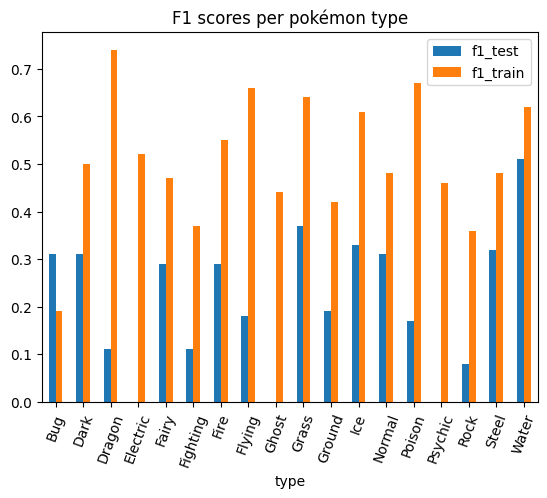

In [9]:
classes_dataframe.plot.bar(x="type", y=["f1_test", "f1_train"], rot=70, title="F1 scores per pokémon type") # type: ignore
plot.show(block=True)

The plotted F1 score shows that the  difference of the F1 scores follows the same pattern as the overall hamming score. The test scores are similar or worse than the training scores in all classes. Due to the low overall number of data, this plot should be taken with a grain of salt. 

Finally, in the context of overfitting, it is of interest to see how much the model could have overfit given time. Our training setup used the model with the best validation score. However, it was configured to continue for 25 more epochs and recoreded the scores over these epochs.

Below is a comparison plot of the development training and validation loss over the traing duration. 

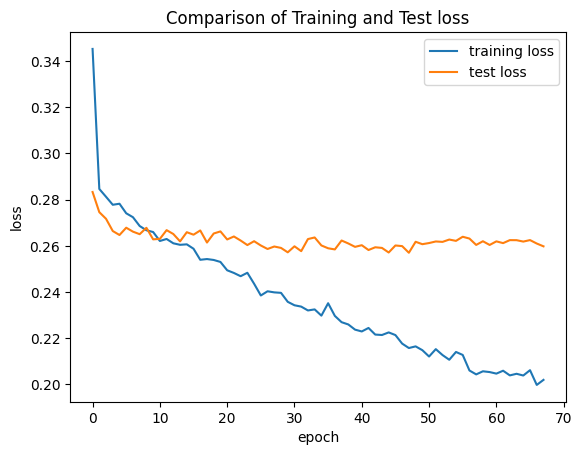

In [10]:
# plot training history
plot.plot(history.history["loss"], label="training loss")
plot.plot(history.history["val_loss"], label="test loss")
plot.legend()
plot.title("Comparison of Training and Test loss")
plot.ylabel("loss")
plot.xlabel("epoch")
plot.show()

The plot shows clear signs of overfitting. After about 5 epochs, the training and validation scores diverge. By epoch 35, the training score already is about 20% lower on the training set. The training score shows no sign of flattening and thus may diverge even more if given more epochs.

# 6) Model Persistence
In this section we do not test anything. We merely store the learned model to hard drive via the below cell.

In [11]:
save_model(
    ml_library="tensorflow",
    model=model,
    model_name="Pokemon_CNN",
    model_version=1,
    model_dir_version=1
)

Storing the model Pokemon_CNN in:
C:\Users\frank\Documents\Teaching\LU\Spring2023\Machine Learning² Unit\Machine Learning Example Project\models\snapshots\Pokemon_CNN_V_1
The model is successfully saved:

    - Model Name: Pokemon_CNN
    - Model Saving Path: C:\Users\frank\Documents\Teaching\LU\Spring2023\Machine Learning² Unit\Machine Learning Example Project\models\snapshots\Pokemon_CNN_V_1\Pokemon_CNN_v_1.h5


# 7) Conclusion:

Sections 2 to 4 showed that while our model beats the naive benchmarks (Section 2) and is fast enough for our purposes (Section 4), it does not exhibit the necessary quality of prediction (Section 3).

This means, while we could techincally use our model for the intended purpose, it performs very badly. However, since our purpose is only to build a teaching demonstrator, this is not an issue.


As the discussion of overfitting shows, the final result still is affected by a significant degree of overfitting. Connecting this result with earlier findings, we believe that the reason is the low amount of data per pokemon class, which reduces the variance of input that can be shown to the model during training ad thus also reduces the ability of the model to generalize to new Pokemon. 

If we extend this project in future work, an extension of the data basis needs to be a big part of it.

